# <center>Projet : Prévision Indice S&P</center>

Vous avez carte blanche pour définir le contour de votre outil mais ce dernier doit au moins
présenter les fonctionnalités suivantes :
<ul>
   
<li>Analyse exploratoire des données d'entrée (ici le SP500) avec une restitution graphique utilisant la librairie matplotlib.</li>
<li>Proposer au moins 3 modèles de calibration et de prévision, dont un réseau de neurones
utilisant la librairie tensorflow. Pour les deux autres modèles, vous utiliserez obligatoirement les librairies sklearn et numpy.</li>
<li>Intégrer le projet dans un contexte professionnel pour la restitution de votre travail</li> 
</ul>

In [132]:
import random

import pandas            as pd 
import numpy             as np
import tensorflow        as tf
import matplotlib.pyplot as plt
import seaborn           as sns

from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set(style="whitegrid")
random.seed(42)



Dans cette partie, nous chargons la base de données qui contient 502 colonnes avec :
<ul>
<li>Colonne 1 [DATE]  : Qui représente le timestamp en Unix time ( secondes ) et qui s'incrémente de 60 secondes entre chaque 2 enregistrements</li>
<li>Colonne 2 [SP500] : La valeur de l'indice S&P500 au timestamp actuel </li>
<li>Colonnes 3 à 502  : Les valeurs de l'indice des 500 entreprises
</ul>

En premier lieu nous affichons une premire visualisation de l'évolution de ces indices, ainsi qu'un boxplot et des histogrammes pour avoir une idée sur la distribution des données

In [3]:
stock_df = pd.read_csv("data_stocks.csv", sep=";")


print(stock_df.head())
print(stock_df.index)


START_DATE = 100               # Indice de début pour la visualisation
STOP_DATE  = 150               # Indice de fin pour la visualisation
COLS       = [1,2,3,4,5,6,7,8] # Les colonnes à afficher


# Figures 
fig, axs = plt.subplots(int(len(COLS)/2) + 1 , 2, figsize = (15,15))
fig.tight_layout(pad=8.0)

# Affichage Evolution
for index in COLS:
    axs.plot(range(START_DATE,STOP_DATE), stock_df[stock_df.columns[index]][START_DATE:STOP_DATE])
    axs.set_xlabel("Jour")
    axs.set_xticklabels([pd.to_datetime(day, unit='s').strftime('%Y-%m-%d %H:%M') for day in stock_df['DATE'][START_DATE : STOP_DATE].values], rotation = 50)
    axs.set_ylabel("Prix des indices ")
    axs.set_title(stock_df.columns[index])
    
plt.show()
plt.clf()
# Box Plots
COLS = COLS[1:]

ax1   = sns.boxplot(data=stock_df[[stock_df.columns[c] for c in COLS]], orient="h", palette="Set2")




NameError: name 'pd' is not defined

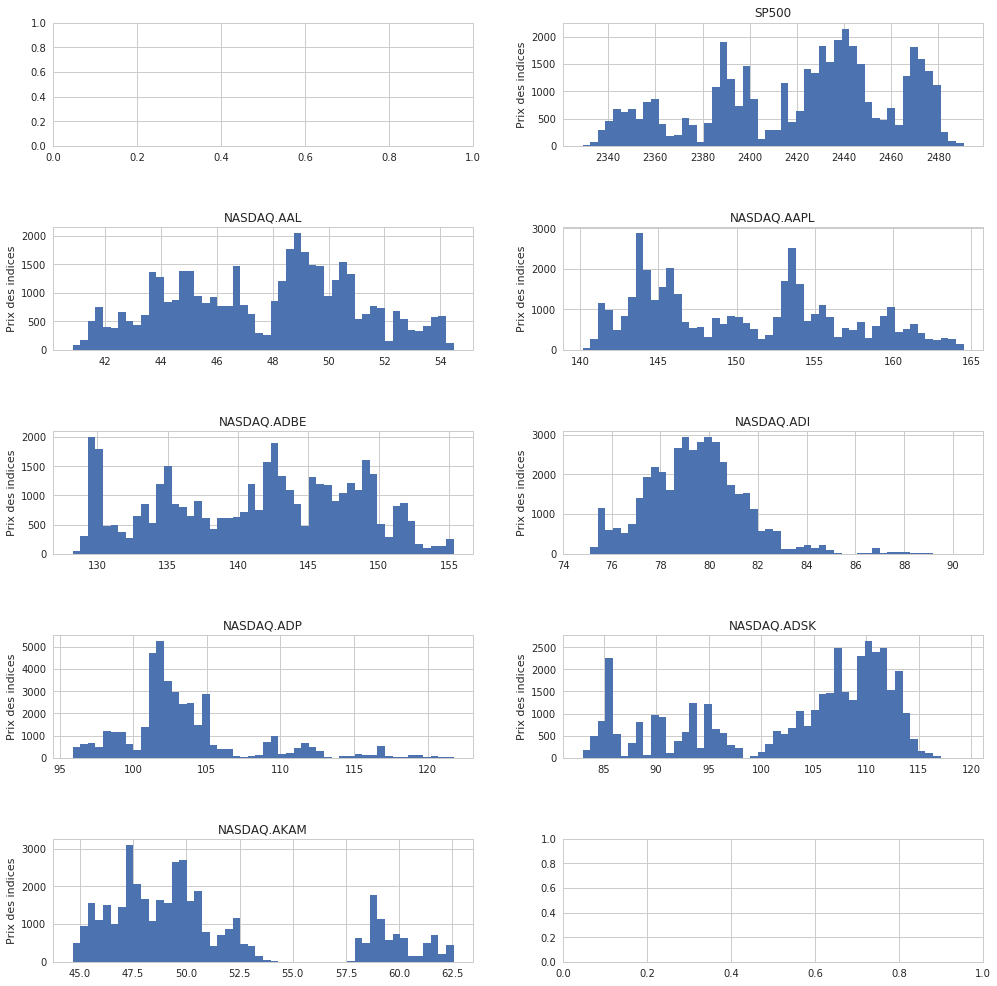

In [200]:
COLS       = [1,2,3,4,5,6,7,8]
fig, axs = plt.subplots(int(len(COLS)/2) + 1 , 2, figsize = (15,15))
fig.tight_layout(pad=5.0)



for idx in COLS:
    axs[idx // 2][idx % 2].hist(stock_df[stock_df.columns[idx]], bins=50)
    axs[idx // 2][idx % 2].set_ylabel("Prix des indices")
    axs[idx // 2][idx % 2].set_title(stock_df.columns[idx])
    
plt.show()



### Séparation Inputs et outputs

Selon les derniers graphes, les indices n'ont pas une distribution particulière (ne se fient pas à une loi de probabilité connue).

Il est aussi à remarquer que chaque indice a ses propres plages de variations. Nous avons donc intêret d'abord à séparer les inputs des outputs, et de rendre les données à la même échelle avant implémentation de tout modèle d'apprentissage.

In [184]:
feature_cols  = []

for col in stock_df.columns:
    if col not in ['DATE', 'SP500']:
        feature_cols.append(col)
      
X = stock_df[feature_cols].values
Y = stock_df["SP500"].values
Y = np.array([[elem] for elem in Y])

print(X[:5])
print(Y[:5])

[[ 42.33   143.68   129.63   ...  63.86   122.      53.35  ]
 [ 42.36   143.7    130.32   ...  63.74   121.77    53.35  ]
 [ 42.31   143.6901 130.225  ...  63.75   121.7     53.365 ]
 [ 42.37   143.64   130.0729 ...  63.88   121.7     53.38  ]
 [ 42.5378 143.66   129.88   ...  63.91   121.695   53.24  ]]
[[2363.6101]
 [2364.1001]
 [2362.6799]
 [2364.3101]
 [2364.8501]]


### Standardisation

La méthode de standardisation que nous allons appliquer est le minmax scaler qui est défini comme suit.<br/>

Soit la colonne $X_i$<br/>

$X_i = \frac{X_i - moyenne(X_i)}{max(X_i) - min(X_i)}$

In [201]:
SS = MinMaxScaler()
X_norm = SS.fit_transform(X)
Y_norm = SS.fit_transform(Y)

print(X_norm[:20])
print(Y_norm[:20])


    

[[0.10993038 0.14455852 0.05131045 ... 0.04878049 0.5092156  0.09098787]
 [0.11212898 0.14537988 0.0767811  ... 0.04017217 0.49935705 0.09098787]
 [0.10846464 0.14497331 0.07327427 ... 0.04088953 0.49635662 0.09228769]
 ...
 [0.11506046 0.15852156 0.08250277 ... 0.05164993 0.50909559 0.09532062]
 [0.11432759 0.15646817 0.0786268  ... 0.05021521 0.50750107 0.09618718]
 [0.11799194 0.15893224 0.07899594 ... 0.04878049 0.51135877 0.09445407]]
[[0.21342456]
 [0.21645842]
 [0.20766516]
 [0.21775865]
 [0.2211021 ]
 [0.22586961]
 [0.22326853]
 [0.22382577]
 [0.21782057]
 [0.21980063]
 [0.21943038]
 [0.2188106 ]
 [0.22345428]
 [0.22611603]
 [0.22351619]
 [0.22401214]
 [0.22178255]
 [0.21831466]
 [0.22042041]
 [0.21546653]]


On obtient finallement des vecteurs avec des valeurs toutes comprises entre -1 et 1

### Séparation entrainement, Test

Avant d'implémenter un modèle d'apprentissage. Il faut répartir nos données en set d'entrainement et set de test pour tester la capacité de notre modèle à généraliser : En évaluant les performances d'un modèles sur des données qui n'ont
    pas été vu au cours de l'entrainement, si elles sont bonnes, cela veut dire que l'entrainement a été effectué d'une façon équilibré, et nos prévisions sont valables
    pour toutes les données suivant la même distribution. En revanche une dégradation des performances sur l'ensemble de test, nous montre que le modèle, se fie trop aux données vu en entrainement ( Overfitting ).<br/>
    
Ainsi notre schéma de subdivision dans ce cas est : <br/>
<ul>
    <li>Training 95%, Test 5%</li>
</ul>

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, Y_norm, test_size=0.05, random_state=1)
print("La taille du dataset utilisé pour l'entrainement : {}".format(len(y_train)))
print("La taille du dataset utilisé pour le test : {}".format(len(y_test)))
y_train = y_train.flatten()
y_test  = y_test.flatten()


La taille du dataset utilisé pour l'entrainement : 39202
La taille du dataset utilisé pour le test : 2064


### Réseau de neurones fully connected 

Selon les figures précedentes, nous remarquons qu'il n'ya pas une tendance déterministe sur nos série, ou des formes peudo-périodique. Ainsi en absence d'hypothèses concernant le lien entre nos données, nous estimons que S&P500 est fun fonction complexe des 500 indices. Le meilleur modèle permettant d'avoir une approximation de cette fonction, en présence de telles ambiguités sont les réseaux de neurons. <br/>

Comme la taille de l'entrée pour notre modèle restera toujours fixe, nous allons choisir d'utiliser un réseau de neurones fully connected ( chaque neurons d'une couche est connecté à tous les neurons de la couche d'avant ).<br/>

Selon des recommendations de l'état de l'art, nous utiliserons un modèle avec l'architecture suivante.<br/>

<img src = 'img/architecture.png' />

Concernant la taille du batch, le nombre de couches cachées, le nombre de neurone par couche cachée, ce sont des hyperparamètres qu'on fixe au début.
pour plus de réglage on peut utiliser la fonction (GridSearch).

In [137]:
# Déclaration des constantes importantes
batch_size    = 256
number_stocks = 500

X = tf.placeholder(dtype=tf.float32, shape=[None, number_stocks])
Y = tf.placeholder(dtype=tf.float32, shape=[None])

In [84]:

# Architecture du Réseaux de neurons
n_stocks = 500
n_neurons_1 = 1024
n_neurons_2 = 512
n_neurons_3 = 256
n_neurons_4 = 128
n_target = 1

# Initializeur de poids
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

# Couche 1 : 1024 neurones
W_hidden_1 = tf.Variable(weight_initializer([n_stocks, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))

# Couche 2: 512 neurones
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))

# Couche 3: 256 neurones
W_hidden_3 = tf.Variable(weight_initializer([n_neurons_2, n_neurons_3]))
bias_hidden_3 = tf.Variable(bias_initializer([n_neurons_3]))

# Couche 4: 128 neurones
W_hidden_4 = tf.Variable(weight_initializer([n_neurons_3, n_neurons_4]))
bias_hidden_4 = tf.Variable(bias_initializer([n_neurons_4]))

# Couche Output : 1 neurone
W_out = tf.Variable(weight_initializer([n_neurons_4, n_target]))
bias_out = tf.Variable(bias_initializer([n_target]))

# Implémentation des relations entre couches
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.relu(tf.add(tf.matmul(hidden_2, W_hidden_3), bias_hidden_3))
hidden_4 = tf.nn.relu(tf.add(tf.matmul(hidden_3, W_hidden_4), bias_hidden_4))

# Couche de sortie
out = tf.transpose(tf.add(tf.matmul(hidden_4, W_out), bias_out))

# La loss function
mse = tf.reduce_mean(tf.squared_difference(out, Y))

# Optimiseur
opt = tf.train.AdamOptimizer().minimize(mse)




In [85]:
print(X_test.shape)

(2064, 500)


La fonction de loss que nous avons utilisé est la MSE loss qui s'exprime de la façon suivante :

$MSE = \frac{1}{N}\sum{n \in [1,N]}(y_i - pred_i)^2$

### Entrainement du réseau 


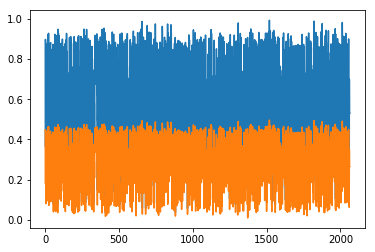

Epoch 0, Batch 0
Epoch 0, Batch 5
Epoch 0, Batch 10
Epoch 0, Batch 15
Epoch 0, Batch 20
Epoch 0, Batch 25
Epoch 0, Batch 30
Epoch 0, Batch 35
Epoch 0, Batch 40
Epoch 0, Batch 45
Epoch 0, Batch 50
Epoch 0, Batch 55
Epoch 0, Batch 60
Epoch 0, Batch 65
Epoch 0, Batch 70
Epoch 0, Batch 75
Epoch 0, Batch 80
Epoch 0, Batch 85
Epoch 0, Batch 90
Epoch 0, Batch 95
Epoch 0, Batch 100
Epoch 0, Batch 105
Epoch 0, Batch 110
Epoch 0, Batch 115
Epoch 0, Batch 120
Epoch 0, Batch 125
Epoch 0, Batch 130
Epoch 0, Batch 135
Epoch 0, Batch 140
Epoch 0, Batch 145
Epoch 0, Batch 150
Epoch 1, Batch 0
Epoch 1, Batch 5
Epoch 1, Batch 10
Epoch 1, Batch 15
Epoch 1, Batch 20
Epoch 1, Batch 25
Epoch 1, Batch 30
Epoch 1, Batch 35
Epoch 1, Batch 40
Epoch 1, Batch 45
Epoch 1, Batch 50
Epoch 1, Batch 55
Epoch 1, Batch 60
Epoch 1, Batch 65
Epoch 1, Batch 70
Epoch 1, Batch 75
Epoch 1, Batch 80
Epoch 1, Batch 85
Epoch 1, Batch 90
Epoch 1, Batch 95
Epoch 1, Batch 100
Epoch 1, Batch 105
Epoch 1, Batch 110
Epoch 1, Batch 115

In [86]:
# Début de session d'apprentissage
net = tf.Session()

# Initialisation des poids
net.run(tf.global_variables_initializer())

# Nombre d'epochs 
epochs = 10
batch_size = 256

for e in range(epochs):

    # Mélange aléatoire des indices du dataset
    shuffle_indices = np.random.permutation(np.arange(len(y_train)))
    X_train = X_train[shuffle_indices]
    y_train = y_train[shuffle_indices]

    # Minibatch training
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        batch_x = X_train[start:start + batch_size]
        batch_y = y_train[start:start + batch_size]
        # Execution de l'optimiseur sur un batch
        net.run(opt, feed_dict={X: batch_x, Y: batch_y})
        # Affichage de la progression
        if np.mod(i,5) == 0:
            print('Epoch ' + str(e) + ', Batch ' + str(i))
        """
        
        if np.mod(i, 5) == 0:
            # Prediction
            pred = net.run(out, feed_dict={X: X_test[start:start + batch_size]})
            line2.set_ydata(pred)
            plt.title('Epoch ' + str(e) + ', Batch ' + str(i))
            file_name = 'img/epoch_' + str(e) + '_batch_' + str(i) + '.jpg'
            plt.savefig(file_name)
            plt.pause(0.01)
        """
        


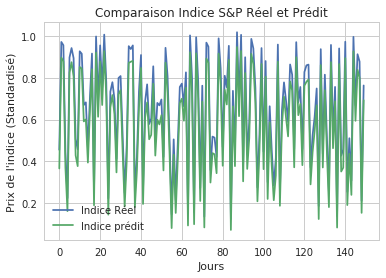

L'érreur MSE est égale à : 0.00539154838770628


In [131]:
pred = net.run(out, feed_dict={X: X_test})

#Plot des performances 
plt.clf()
plt.plot(range(150), pred[0][:150])
plt.plot(range(150), y_test[:150])
plt.title('Comparaison Indice S&P Réel et Prédit')
plt.xlabel('Jours')
plt.ylabel("Prix de l'indice (Standardisé)")
plt.legend(["Indice Réel","Indice prédit"])
plt.show()

# L'erreur finale
mse_final = net.run(mse, feed_dict={X: X_test, Y: y_test})
print("L'érreur MSE est égale à : {}".format(mse_final))


## Prévision avec régression linéaire 

Dans cette partie nous supposerons l'existence d'une relation linéaire entre nos données ( Hypothèse que l'on cherchera à valider par la suite ) et nous essayerons de mettre en place un modèle de régression linéaire.

Ainsi dans un premier temps nous essayerons de faire une regression en fonction de tout les 500 features, en utilisant les données standardisés et la même subdivision pour le set, entrainement - test

La MSE pour le modèle est : 6.91329941919845e-06
Le coefficient R2 est égale à : 0.9998880188955863


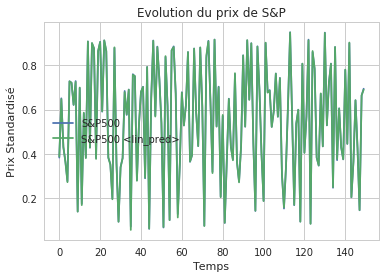

In [203]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Le modèle de regression linéaire 
reg             = LinearRegression().fit(X_train, y_train)
pred            = reg.predict(X_test)

mse_regression  = 0 

for i in range(len(y_test)):
    mse_regression += ((y_test[i] - pred[i])**2)

mse_regression = mse_regression/len(y_test)
r2             = reg.score(X_test, y_test)

print("La MSE pour le modèle est : {}".format(mse_regression))
print("Le coefficient R2 est égale à : {}".format(r2))

# Plot comparatif entre modèle réel et estimé
plt.clf()
plt.plot(range(150), y_test[150:300])
plt.plot(range(150), pred[150:300]  )
plt.title("Evolution du prix de S&P")
plt.xlabel("Temps")
plt.ylabel("Prix Standardisé")
plt.legend(["S&P500", "S&P500 <lin_pred>"])
plt.show()


Ce modèle est très performant, et donne une erreur de 6.91329941919845e-06, Ce qui nous pousse à considérer l'existence d'une relation linéaire entre toutes ces variables. Le coefficient R2 ici est proche de 1, ce qui signifie que le modèle explique bien la variance des données.

Nous regardons les coefficients de regression qui ont été utilisé : 

In [204]:
print("L'intercept est : {}".format(reg.intercept_))
print("Les poids associées aux variables (Dans l'ordre) sont : {}".format(reg.coef_))

L'intercept est : -0.7088340455673819
Les poids associées aux variables (Dans l'ordre) sont : [ 4.55637718e-03  8.92175523e-02  8.00567064e-03  3.86160715e-03
  1.20571799e-02  7.77841306e-03  5.14699114e-03  3.84916785e-03
  7.04566042e-03  1.52087021e-03  1.23316348e-02  5.85904392e-02
  6.63866444e-03  1.62429750e-02  1.48616195e-03  7.99658116e-03
 -8.55133254e-04  7.33966070e-03  1.40809976e-02  3.72268281e-03
  4.48612738e-03  7.88168504e-03 -8.27518709e-04  1.81037647e-02
 -5.41679488e-04  6.17610006e-03  1.46723798e-02  5.39248843e-03
 -4.69875460e-04  9.81259744e-03  3.77920077e-04  3.23244844e-03
  1.60188372e-03  2.76876620e-03  2.33853938e-03  7.11756678e-03
  4.51868175e-03  7.40562343e-04  6.96496761e-03  5.96695485e-04
  2.29852235e-03  2.45123558e-03  6.78127538e-03  6.63614375e-02
  2.99307483e-04  2.77686815e-03  5.26585663e-03  5.21693652e-04
 -6.22340516e-03  1.49455157e-02  1.66376905e-02  3.21630552e-02
  3.49414578e-02 -9.80822156e-04 -7.23945560e-04  4.53500716e

## Validation hypothèse linéarité (Normalité des résidus)

Nous nous intéressons cette fois-ci au plot des résidus, si notre hypothèse est valable
les résidus doivent avoit une allure gaussienne

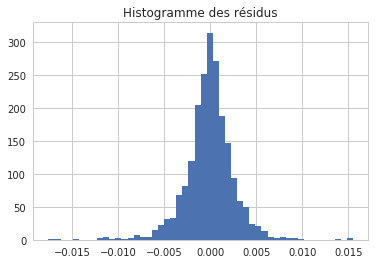

La skewness de la série est : -0.4215548463365436
Le curtosis de la série est : 5.120043768341926


In [205]:
from scipy.stats import kurtosis
from scipy.stats import skew


res = [(y_test[i] - pred[i]) for i in range(len(y_test))]

# Plot de l'histogramme des résidus
plt.clf()
plt.hist(res, bins=50)
plt.title("Histogramme des résidus")
plt.show()


print("La skewness de la série est : {}".format(skew(res)))
print("Le curtosis de la série est : {}".format(kurtosis(res)))



Ainsi comme nous nous attendions, les résidus suivent un profil gaussien , confirmé aussi par
les valeurs des skewness et curtosis. qui s'interprètent comme suit : 

<img src = "img/skw.gif" />

## Prévision avec arbre de regression

Nous implémentons pour ce dernier cas un arbre de regression. Dans ces structures d'arbre, les feuilles représentent les valeurs de la variable-cible et les embranchements correspondent à des combinaisons de variables d'entrée qui mènent à ces valeurs.
En analyse de décision, un arbre de décision peut être utilisé pour représenter de manière explicite les décisions réalisées et les processus qui les amènent.<br/><br/>
Dans notre cas nous ne pouvons pas visualiser cela puisque la taille de l'arbre sera assez grande. Nous nous contentons que de la mesure de performance finale <br/>



La MSE pour le modèle est : 3.3494667728674657e-09


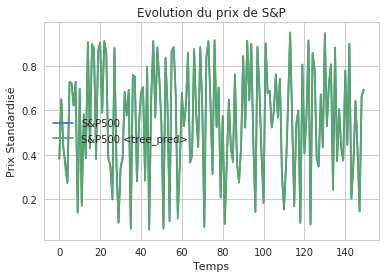

In [154]:
from sklearn.tree import DecisionTreeRegressor

reg_tree        = DecisionTreeRegressor()
reg_tree.fit(X_train, y_train)

pred_tree       = reg_tree.predict(X_test)

mse_tree        = 0 

for i in range(len(y_test)):
    mse_tree   += ((y_test[i] - pred[i])**2)

mse_regression  = mse_regression/len(y_test)

print("La MSE pour le modèle est : {}".format(mse_regression))

# Plot comparatif entre modèle réel et estimé
plt.clf()
plt.plot(range(150), y_test[150:300])
plt.plot(range(150), pred_tree[150:300]  )
plt.title("Evolution du prix de S&P")
plt.xlabel("Temps")
plt.ylabel("Prix Standardisé")
plt.legend(["S&P500", "S&P500 <tree_pred>"])
plt.show()

Comme nous voyons, le modèle "Regression tree" est le plus performant parmis tous les autres.